In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.test.is_gpu_available()

True

# Parameters

In [ ]:
# EVSI rank: xmv_10, xmeas_33, xmv_4, xmeas_25, xmeas_21, xmeas_35
sensors = ['<EngSpd>',
 'FuelFlw',
 '<EngTrq>',
 '<ThrPosPct>',
 '<Acc>',
 'VelocityRef:1',
 '<BattSoc>',
 '<xdot>',
 '<WgAreaPct>',
 '<BattPwr>']
model_path = '/content/drive/MyDrive/models/' + '0_' + 'none' + '/'

# Data Loading

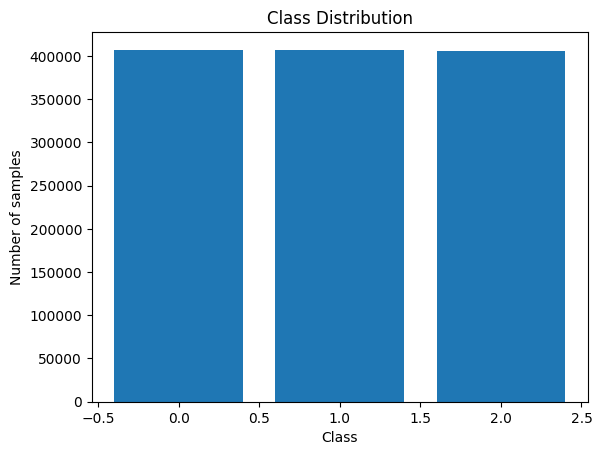

In [ ]:
Sampled_train = pd.read_csv("/content/drive/MyDrive/Dataset_RP/traincsv.csv")
Sampled_train = pd.concat([Sampled_train,pd.read_csv("/content/drive/MyDrive/Dataset_RP/train12csv.csv")])

class_distribution = Sampled_train['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for i in range (3):
  for j in range (1,3):
    Sample_temp = Sampled_train[Sampled_train['faultNumber']==i]
    Sample_temp = Sample_temp[Sample_temp['simulationRun']==j]
    begin = 0
    train_size = int(((len(Sample_temp)) * 0.6)/20)
    val_size = int(((len(Sample_temp) * 0.2)/20))
    test_size = int(((len(Sample_temp) * 0.2)/20))

    for k in range (1,21):
      train_data =pd.concat([train_data,Sample_temp[begin:begin+train_size]])
      val_data = pd.concat([val_data,Sample_temp[begin+train_size:begin+train_size+val_size]])
      test_data = pd.concat([test_data,Sample_temp[begin+train_size+val_size:begin+train_size+val_size+test_size]])
      begin = begin+train_size+val_size+test_size
Sampled_train = train_data
Sampled_cv = val_data
Sampled_test = test_data

##### Preprocessing

In [ ]:
# Drop some mysterious fault type
Sampled_train.drop(Sampled_train[(Sampled_train.faultNumber == 3) | (Sampled_train.faultNumber == 9) | (Sampled_train.faultNumber == 15)].index, inplace = True)
Sampled_test.drop(Sampled_test[(Sampled_test.faultNumber == 3) | (Sampled_test.faultNumber == 9) | (Sampled_test.faultNumber == 15)].index, inplace = True)
Sampled_cv.drop(Sampled_cv[(Sampled_cv.faultNumber == 3) | (Sampled_cv.faultNumber == 9) | (Sampled_cv.faultNumber == 15)].index, inplace = True)

In [ ]:
# make the Y value usable in LSTM
y_train = to_categorical(Sampled_train['faultNumber'],num_classes=3)
y_test = to_categorical(Sampled_test['faultNumber'],num_classes=3)
y_cv = to_categorical(Sampled_cv['faultNumber'],num_classes=3)

In [ ]:
y_train[0]

array([1., 0., 0.], dtype=float32)

In [ ]:
# drop unused meta data from x
x_train_df = Sampled_train.drop(['faultNumber','simulationRun','sample'],axis=1)
x_test_df = Sampled_test.drop(['faultNumber','simulationRun','sample'],axis =1)
x_cv_df = Sampled_cv.drop(['faultNumber','simulationRun','sample'],axis =1)

In [ ]:
x_test_df

,VelocityRef:1,<xdot>,<BattSoc>,<BattPwr>,<Cltch1State>,<Cltch2State>,<BattV>,<TransGear>,<EngSpd>,<IntkVlvLift>,...,<MotTrq>,<StartTrq>,StartCmd,MotTrqCmd,BattCrnt:1,MotPwrElec:1,MotPwrMech:1,IntkVlvLiftCmd,FuelMainSoi,FuelFlw
8150,7.078655,7.281186e+00,58.933057,-6862.252524,1,1,273.657197,3,1261.435448,0,...,-61.501718,-4.600000e-81,0,-61.362940,-25.076090,-6987.188751,-8118.924267,0,0,0.0
8151,7.073961,7.276460e+00,58.933714,-6854.915682,1,1,273.655901,3,1260.615778,0,...,-61.477637,-3.530000e-81,0,-61.344655,-25.049398,-6979.975202,-8110.469040,0,0,0.0
8152,7.069267,7.271735e+00,58.934370,-6847.710085,1,1,273.654633,3,1259.796223,0,...,-61.454618,-2.810000e-81,0,-61.328105,-25.023183,-6972.887253,-8102.158625,0,0,0.0
8153,7.064573,7.267012e+00,58.935025,-6840.632411,1,1,273.653394,3,1258.976775,0,...,-61.432637,-2.310000e-81,0,-61.311556,-24.997433,-6965.920533,-8093.989558,0,0,0.0
8154,7.059879,7.262290e+00,58.935680,-6833.679636,1,1,273.652182,3,1258.157429,0,...,-61.411653,-1.760000e-81,0,-61.296606,-24.972136,-6959.070701,-8085.956139,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608637,2.587500,-9.430000e-23,0.292693,0.000000,0,0,210.619638,1,-0.188301,0,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0
608638,2.583333,-9.430000e-23,0.292693,0.000000,0,0,210.619638,1,-0.188287,0,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0
608639,2.579167,-9.430000e-23,0.292693,0.000000,0,0,210.619638,1,-0.188273,0,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0
608640,2.575000,-9.430000e-23,0.292693,0.000000,0,0,210.619638,1,-0.188259,0,...,0.000000,0.000000e+00,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0


In [ ]:
def feature_remover(features_names):
    # remove a list of features from x

    dimension = dict()

    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)

    # create a copy so we don't change the original dataframe
    x_train_masked_df = x_train_df.copy()
    x_test_masked_df = x_test_df.copy()
    x_cv_masked_df = x_cv_df.copy()

    for feature in features_names:
        x_train_masked_df.drop([feature], axis = 1, inplace = True)
        x_test_masked_df.drop([feature], axis = 1, inplace = True)
        x_cv_masked_df.drop([feature], axis = 1, inplace = True)

    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]

    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)

    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))

    return dimension, x_train, x_test, x_cv

# Models Training

In [ ]:
def train_model(x_train, y_train, x_cv, y_cv, train_col, feature_name):
    model = Sequential()
    model.add(LSTM(256,input_shape= (train_col, 1),return_sequences= True))
    model.add(LSTM(128,return_sequences= False))
    model.add(Dense(300))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    # training
    model.fit(x_train, y_train, epochs=15,verbose=1,batch_size=256,validation_data = (x_cv, y_cv))#120

    # saving the model
    model.save(model_path + feature_name)

    # saving the history
    model_paras = model.history
    with open(model_path + feature_name + '/history.pickle', 'wb') as handle:
        pickle.dump(model_paras.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model

#### Base Model

In [ ]:
dimension, x_train, x_test, x_cv = feature_remover(features_names = sensors)
print(dimension['train_col'])

complete_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], 'base')

22
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               38528     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non-t

#### +1 Model

In [ ]:
for sensor in sensors:
    remove_sensors = sensors.copy()
    remove_sensors.remove(sensor)
    dimension, x_train, x_test, x_cv = feature_remover(features_names = remove_sensors)

    print(dimension['train_col'])

    complete_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], '+' + sensor)

23
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 23, 256)           264192    
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 300)               38700     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               38528     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 23, 256)           264192    
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dense_6 (Dense)             (None, 300)               38700     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               38528     
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 23, 256)           264192    
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dense_9 (Dense)             (None, 300)               38700     
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               38528     
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 23, 256)           264192    
                                                                 
 lstm_9 (LSTM)               (None, 128)               197120    
                                                                 
 dense_12 (Dense)            (None, 300)               38700     
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               38528     
                                                                 
 dense_14 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 23, 256)           264192    
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dense_15 (Dense)            (None, 300)               38700     
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               38528     
                                                                 
 dense_17 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 23, 256)           264192    
                                                                 
 lstm_13 (LSTM)              (None, 128)               197120    
                                                                 
 dense_18 (Dense)            (None, 300)               38700     
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               38528     
                                                                 
 dense_20 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 23, 256)           264192    
                                                                 
 lstm_15 (LSTM)              (None, 128)               197120    
                                                                 
 dense_21 (Dense)            (None, 300)               38700     
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               38528     
                                                                 
 dense_23 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 23, 256)           264192    
                                                                 
 lstm_17 (LSTM)              (None, 128)               197120    
                                                                 
 dense_24 (Dense)            (None, 300)               38700     
                                                                 
 dropout_8 (Dropout)         (None, 300)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               38528     
                                                                 
 dense_26 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 23, 256)           264192    
                                                                 
 lstm_19 (LSTM)              (None, 128)               197120    
                                                                 
 dense_27 (Dense)            (None, 300)               38700     
                                                                 
 dropout_9 (Dropout)         (None, 300)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               38528     
                                                                 
 dense_29 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
Non

23
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 23, 256)           264192    
                                                                 
 lstm_21 (LSTM)              (None, 128)               197120    
                                                                 
 dense_30 (Dense)            (None, 300)               38700     
                                                                 
 dropout_10 (Dropout)        (None, 300)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               38528     
                                                                 
 dense_32 (Dense)            (None, 3)                 387       
                                                                 
Total params: 538,927
Trainable params: 538,927
No

# Lower Branch

# Upper Branch